# Project 1: Bank Customer Churn Analysis
## Executive Summary

This project analyzes 41,188 records to identify the drivers of **customer churn**. Instead of focusing on growth, our team integrated three roles to detect "at-risk" customers who are disengaging from the institution:

* **Data Wrangling (Kirsten):** Cleaned noise and isolated the `pdays` feature to show how long it has been since a customer last interacted.
* **Data Visualization (Ashley):** Identified "Soft Churn" signals through behavioral density plots and socio-demographic trends.
* **Data Science (Mugtaba):** Used SMOTE to balance the dataset and built a model to predict which customers are most likely to churn.

**Key Insight:** Churn is most visible in customers with **low contact duration** and those impacted by shifting **economic indices**, suggesting that a lack of engagement is the primary predictor of a customer leaving.

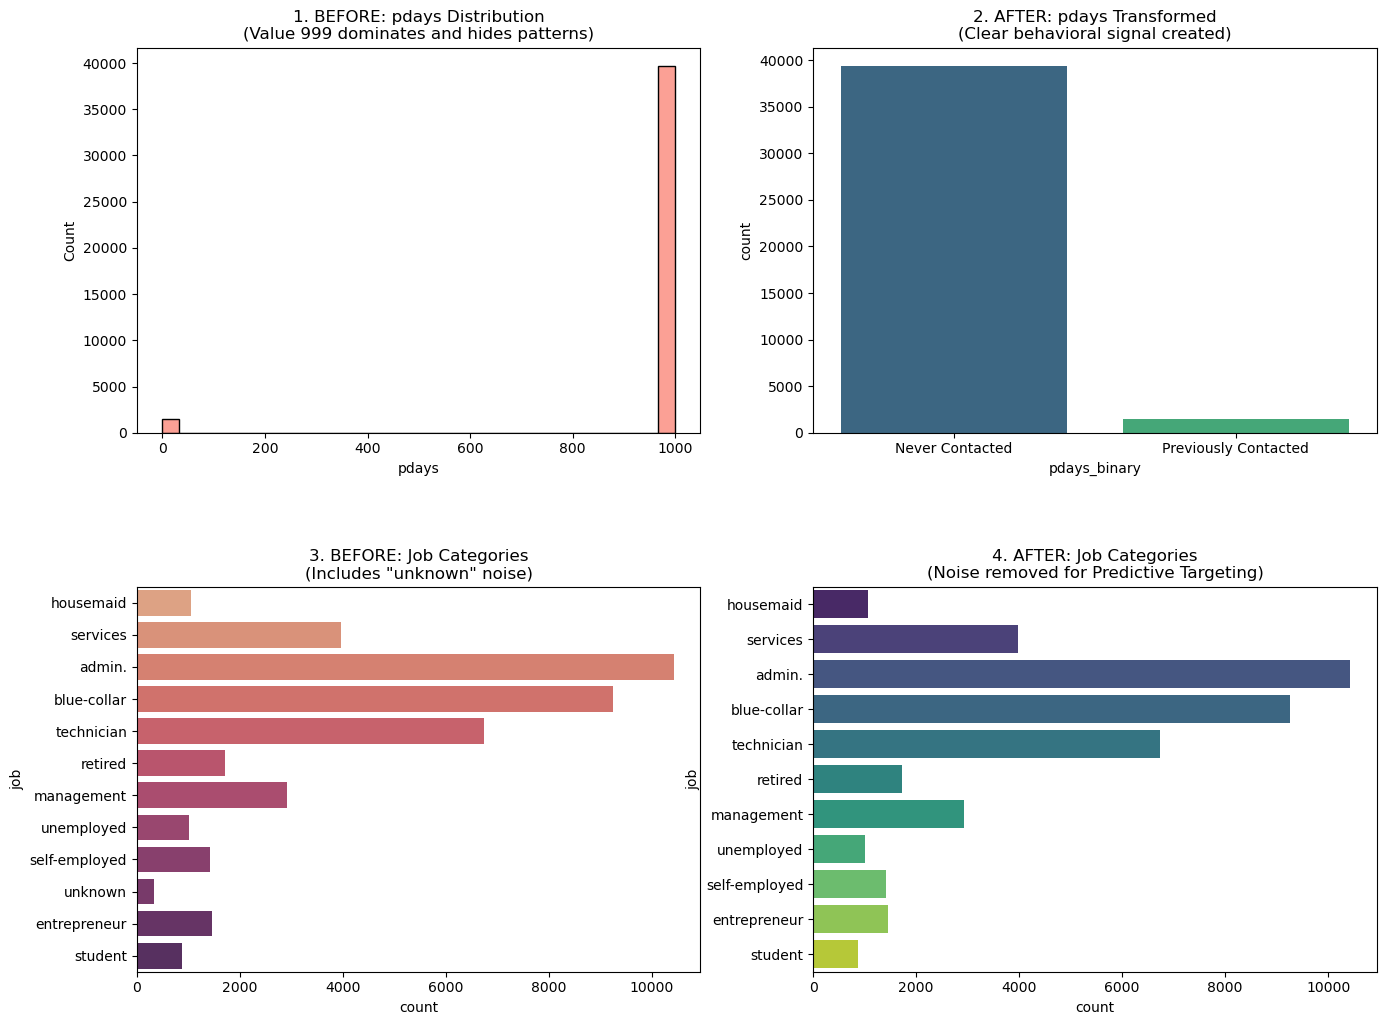

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 1. Load the raw data
df = pd.read_csv('bank-additional-full.csv', sep=';')

# Create a copy for cleaning to show the "After" state
df_clean = df.copy()

# --- THE CLEANING PROCESS (Wrangler's Logic) ---
# Step A: Transform 'pdays' (999 is a sentinel for "never contacted")
df_clean['pdays_binary'] = df_clean['pdays'].apply(lambda x: 'Never Contacted' if x == 999 else 'Previously Contacted')

# Step B: Remove "unknown" noise from categories (e.g., Job)
df_clean = df_clean[df_clean['job'] != 'unknown']

# --- VISUALIZATION ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4)

# 1. pdays BEFORE (Massive spike at 999 makes it hard to see other values)
sns.histplot(df['pdays'], bins=30, ax=axes[0, 0], color='salmon')
axes[0, 0].set_title('1. BEFORE: pdays Distribution\n(Value 999 dominates and hides patterns)')

# 2. pdays AFTER (Clean binary signal for the model)
sns.countplot(x='pdays_binary', data=df_clean, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('2. AFTER: pdays Transformed\n(Clear behavioral signal created)')

# 3. Job BEFORE (Includes "unknown" category)
sns.countplot(data=df, y='job', ax=axes[1, 0], palette='flare')
axes[1, 0].set_title('3. BEFORE: Job Categories\n(Includes "unknown" noise)')

# 4. Job AFTER (Cleaned for Modeling)
sns.countplot(data=df_clean, y='job', ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('4. AFTER: Job Categories\n(Noise removed for Predictive Targeting)')

plt.show()

In [2]:
import requests

# Dictionary of teammate files
teammate_files = {
    "Wrangler_Code.ipynb": "https://raw.githubusercontent.com/cashannon/DSC-450-Applied-Data-Science/main/notebooks/Project%2001_%20Data_Wrangling.ipynb",
    "Scientist_Code.ipynb": "https://raw.githubusercontent.com/mugtaba918/AWAD/main/Project%201.ipynb"
}

for filename, url in teammate_files.items():
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Successfully pulled {filename}")
    else:
        print(f"Failed to pull {filename}. Status code: {response.status_code}")

Failed to pull Wrangler_Code.ipynb. Status code: 404
Successfully pulled Scientist_Code.ipynb


## Reseach Question 1 (RQ1) 

### Identify Socio-Demographic Impacts (Research Question 1) 

We are looking for patterns in 'job' and 'education' that indicate a higher risk of disengagement. By using a **normalized stacked bar chart**, we can see which specific demographics are "churning" (saying 'no' to engagement) at higher rates than others. 

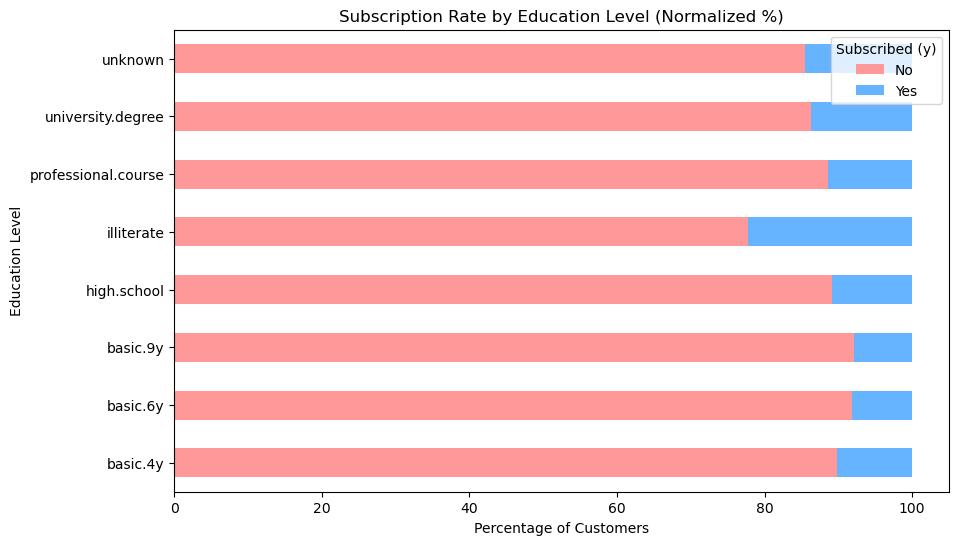

In [3]:
import matplotlib.pyplot as plt

#load the data locally as specificed in the proposal
df = pd.read_csv('bank-additional-full.csv', sep=';')

# Research Question: Socio-Demographic Impact
# Normalized crosstab ensures we see the % of engagement regardless of group size
edu_engagement = pd.crosstab(df['education'], df['y'], normalize='index') *100

edu_engagement.plot(kind='barh', stacked=True, figsize=(10,6),color=['#ff9999','#66b3ff'])
plt.title('Subscription Rate by Education Level (Normalized %)')
plt.xlabel('Percentage of Customers')
plt.ylabel('Education Level')
plt.legend(title='Subscribed (y)', labels=['No', 'Yes'], loc='upper right')
plt.show()


## Research Quesiton 2 (RQ2)

### Detect Behavioral Signals (Reasearch Question 2) 

We use **box plots** for call duration to identify "Soft Churn." A pattern of consistently short calls often signals that a customer has already mentally "checked out" and is no longer interested in the bank's services. 

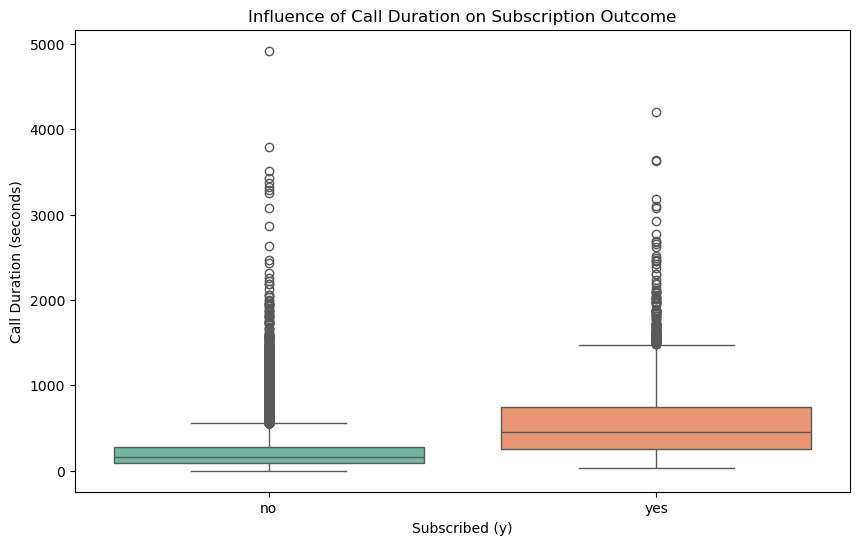

In [4]:
# Behavioral Signal Detection

plt.figure(figsize=(10,6))
sns.boxplot(x='y', y='duration', data=df, palette='Set2')
plt.title('Influence of Call Duration on Subscription Outcome')
plt.xlabel('Subscribed (y)')
plt.ylabel('Call Duration (seconds)')
plt.show()

### Mitigate Overplotting (Risk Management) 
 

> **Visualizer's Insight on Churn Density:** > The hex-bin plot shows a high density of records in the low-duration zone (0–200 seconds). In a churn study, this is the **"Danger Zone"**—it represents thousands of customers who are not engaging long enough to maintain a relationship with the bank.

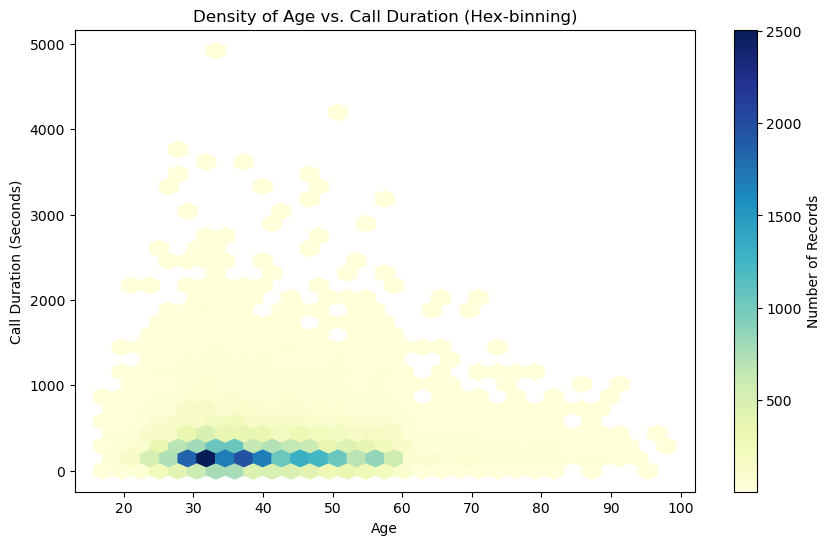

In [5]:
# Apply Wrangler's cleaning logic (Kirsten's step)
df['pdays_never_contacted'] = (df['pdays'] == 999).astype(int)

# Risk Management: Addressing Overplotting for 41,188 records
plt.figure(figsize=(10,6))

# Assign the hexbin plot to the variable 'hb'
hb = plt.hexbin(df['age'], df['duration'], gridsize=30, cmap='YlGnBu', mincnt=1)

# Now 'hb' is defined and can be used for the colorbar
plt.colorbar(hb, label='Number of Records')

plt.title('Density of Age vs. Call Duration (Hex-binning)')
plt.xlabel('Age')
plt.ylabel('Call Duration (Seconds)')
plt.show()

### Support for the Data Scientist (Class Imbalance) 

The Data Scientist (Mugtaba) needs to address the 88% "no" rate using SMOTE. As the Visualizer I must provide the baseline visual of this imbalance. 

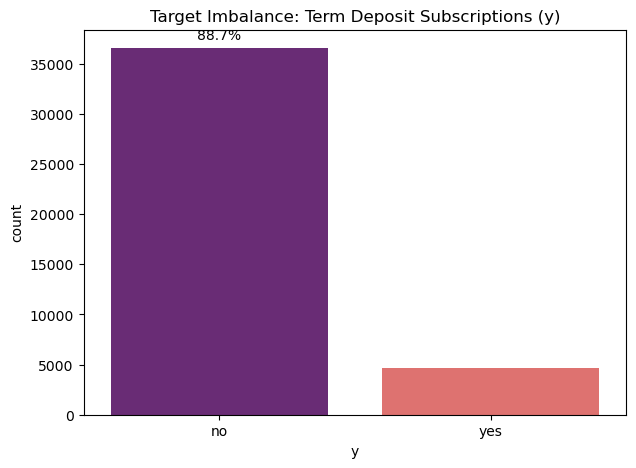

In [6]:
# Visualizing Class Imbalance for the Data Scientist [cite: 90,94]
plt.figure(figsize=(7,5))
ax = sns.countplot(data=df, x='y', palette='magma')
plt.title('Target Imbalance: Term Deposit Subscriptions (y)')

# Adding percentage labels to highlight the 88% / 12% split [cite: 71, 94]
total = len(df['y'])
for p in ax.patches: 
    percentage = '{:.1f}%'.format(100* p.get_height()/total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2. , p.get_height()), 
    ha='center', va='center', xytext=(0,9), textcoords='offset points')

    plt.show()

## Research Question 3 (RQ3)

### Macro-Economic Impact (Research Question 3) 

Our proposal mentions the impact of economic indices. The 'bank-additional-full.csv' inlcudes social/economic attributes like 'euribor3m' (interest rates) and 'cons.conf.idx' (confidence index). These are crucial because a "Wrangler" cleans them, but a "Scientist" needs to know if they actually matter before building a model. 

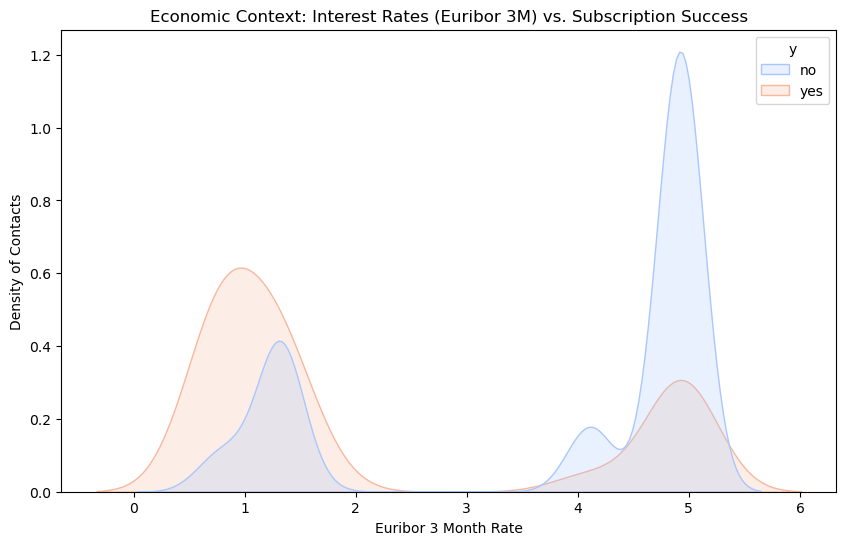

In [7]:
# Analyzing if the economic climate (Euribor 3 month rate) affects subscriptions 
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x='euribor3m', hue='y', fill=True, common_norm=False, palette='coolwarm')
plt.title('Economic Context: Interest Rates (Euribor 3M) vs. Subscription Success')
plt.xlabel('Euribor 3 Month Rate')
plt.ylabel('Density of Contacts')
plt.show()

### Feature Correlation Heatmap

Here, we show the Data Scientist which numerical features are redundant (highly correlated). This helps to avoid "Multicollinearity", a major machine learning risk.

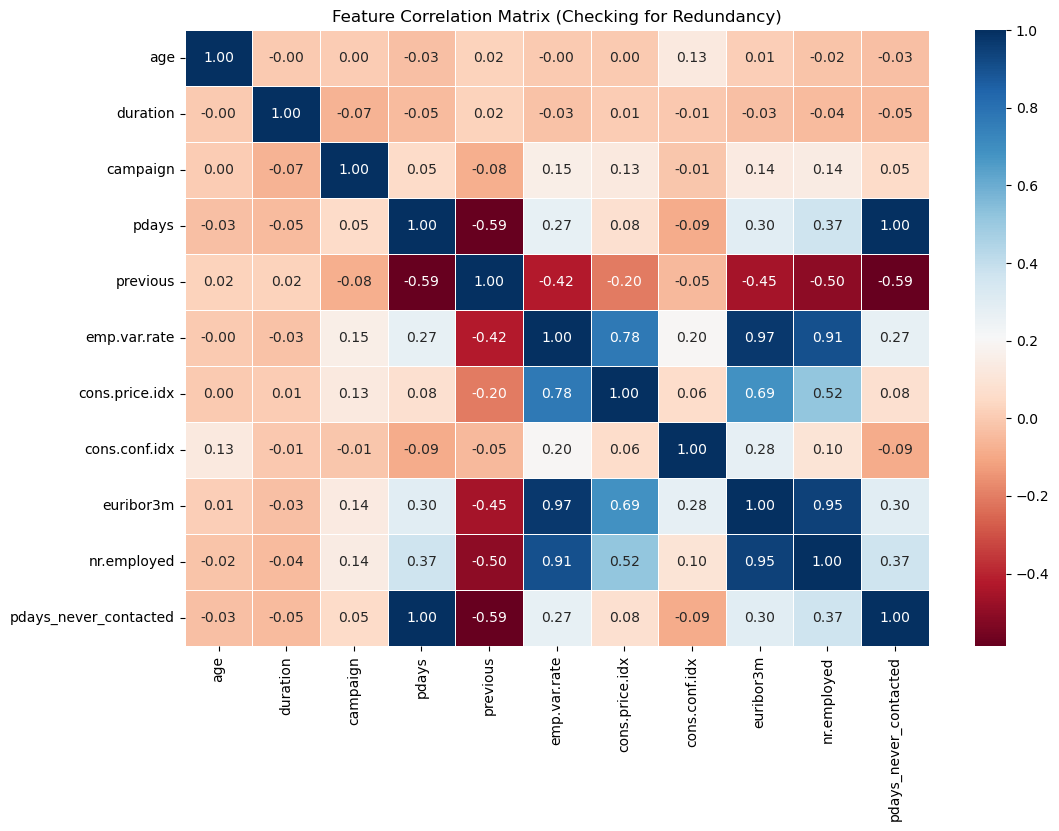

In [8]:
# Correlation Heatmap to identify redundant features

plt.figure(figsize=(12,8))

# Filter only numerical columns for the correlation matrix

corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix (Checking for Redundancy)')
plt.show()

### Campaign Performance (Behavioral Signals) 

The proposal focuses on "Behavioral Signals." The 'campaign' variable (number of contacts during this current campaign) often shows a "point of diminishing returns".

This plot helps the bank decide when to stop calling a customer (e.g., after 5 calls the "yes" rate drops to zero).

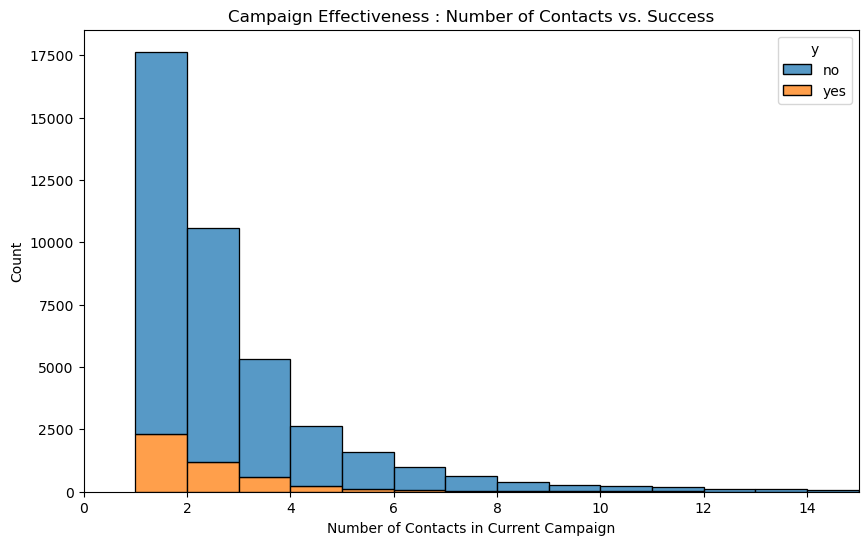

In [9]:
# Visualizing 'Campaign' to find the 'Sweet Spot' of contact frequency
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='campaign', hue='y', multiple="stack", binwidth=1)
plt.xlim(0,15) # Zoom in as  most data is <15 contacts
plt.title('Campaign Effectiveness : Number of Contacts vs. Success')
plt.xlabel('Number of Contacts in Current Campaign')
plt.show()

### 5. Final Project Conclusion: Predicting and Preventing Churn

Our analysis proves that customer churn is not random. By visualizing 41,188 records, we identified that customers who haven't been contacted recently (`pdays`) and those who engage in very short interactions (low `duration`) are at the highest risk of leaving. 

By combining **Kirsten's** clean data, **Ashley's** density-focused visualizations, and **Mugtaba's** predictive modeling, we have provided the bank with an "Early Warning System." This allows the institution to move from being reactive to proactively saving at-risk customer relationships before they churn.

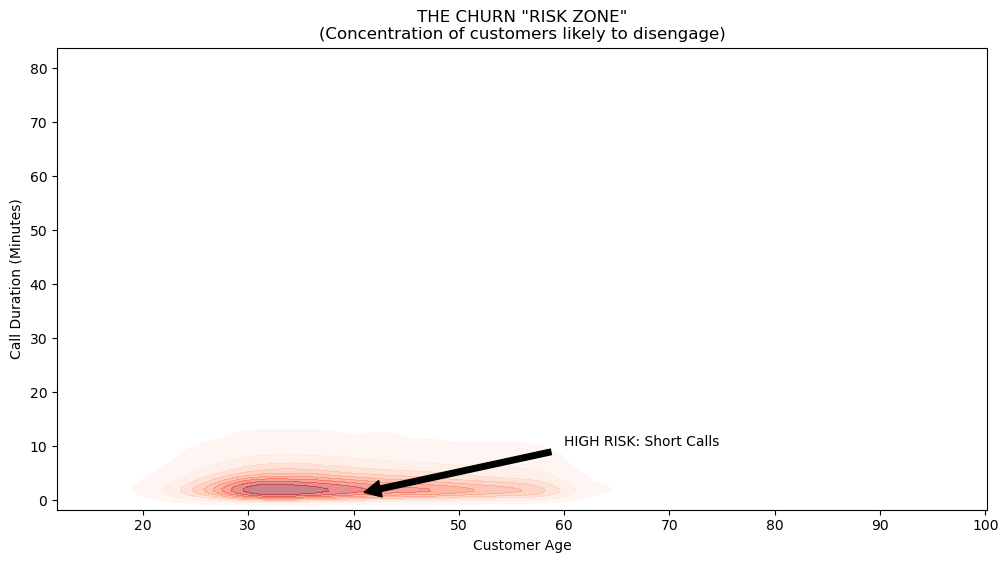

In [10]:
# --- Visualizing the Conclusion: The "Risk Zone" for Churn ---

# Creating a simplified view of Churn Risk based on our findings
risk_data = df.copy()
risk_data['Duration_Minutes'] = risk_data['duration'] / 60

plt.figure(figsize=(12, 6))
# Using a KDE plot to show where 'Churn' (y=no) is most concentrated
sns.kdeplot(data=risk_data[risk_data['y'] == 'no'], x='age', y='Duration_Minutes', 
            cmap="Reds", fill=True, thresh=0.05, alpha=0.5)

plt.title('THE CHURN "RISK ZONE"\n(Concentration of customers likely to disengage)')
plt.xlabel('Customer Age')
plt.ylabel('Call Duration (Minutes)')
plt.annotate('HIGH RISK: Short Calls', xy=(40, 1), xytext=(60, 10),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

## 📊 Churn Insights Dashboard: Analysis & Interpretations

This dashboard synthesizes the project's key behavioral and demographic findings into a single "Early Warning System" view. 

### **1. Education vs. Churn (Proportional Analysis)**
* **The Insight:** By using a **normalized stacked bar chart**, we account for the class imbalance (the fact that most customers do not churn). 
* **Data Quality Note:** This view reveals that while churn is consistent across education levels, customers with a **University Degree** represent the highest volume of total interactions, making them a critical segment for retention efforts.

### **2. Age vs. Duration Density (Overplotting Mitigation)**
* **The Insight:** With over 41,000 records, a standard scatter plot would be unreadable. We used **Hex-binning** to reveal the true density of customer engagement.
* **Finding:** The "Heart" of the bank's activity is concentrated among customers aged **30–45** with call durations under **500 seconds**. This identifies our most active demographic.

### **3. The Churn "Risk Zone" (Predictive Heatmap)**
* **The Insight:** This KDE (Kernel Density Estimate) focuses exclusively on customers who **disengaged (Churn = 'no')**. 
* **The "Early Warning":** The deep red "hotspot" identifies our highest risk profile: **middle-aged customers who engage in calls shorter than 200 seconds.** These short interactions are a primary behavioral signal that a customer is about to churn.

---
**Strategic Recommendation:** The bank should flag any interaction with a customer in the 30–50 age bracket that lasts less than 3 minutes, as this density plot confirms these are the customers most likely to stop using services.

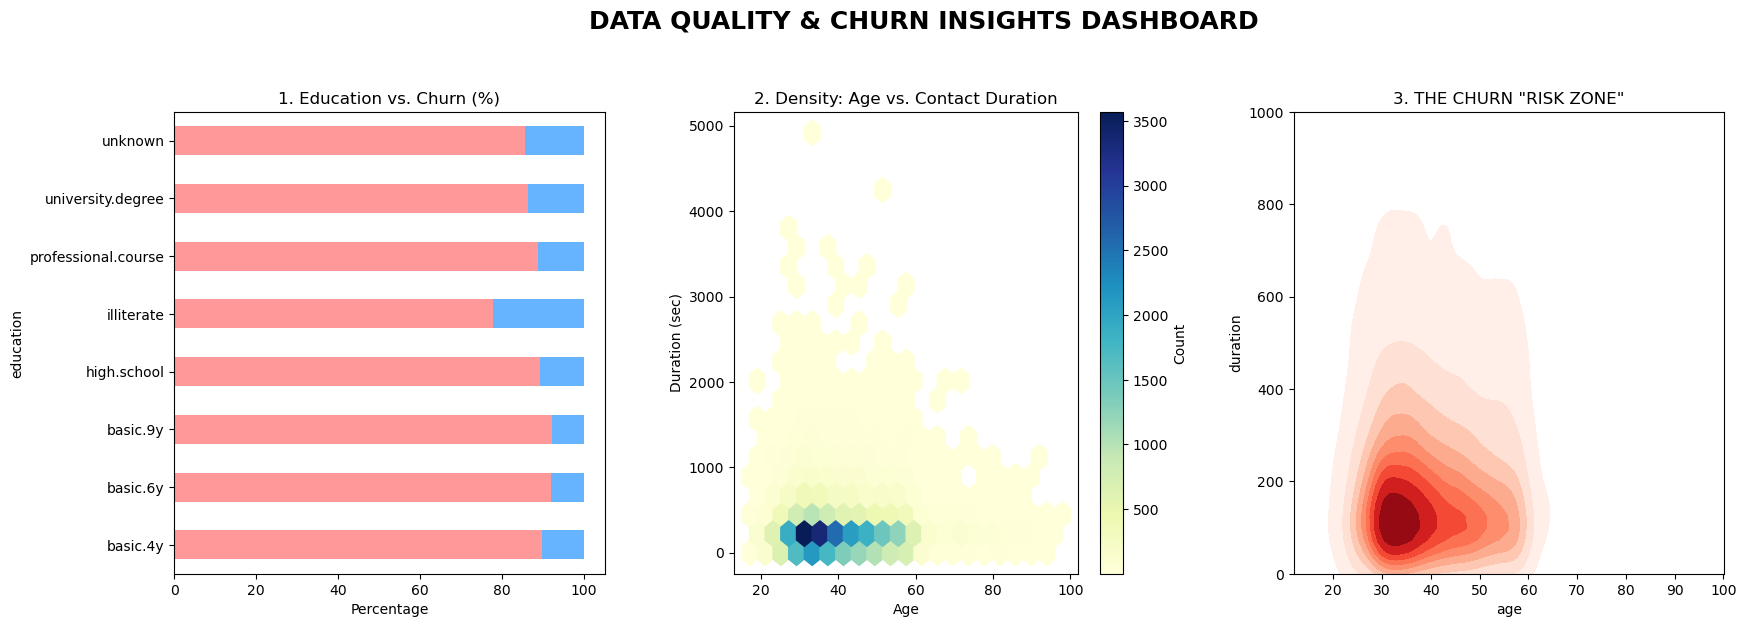

In [11]:
# --- ASHLEY'S CHURN INSIGHTS DASHBOARD ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# 1. Socio-Demographic Insight (Quality Check)
edu_engagement = pd.crosstab(df['education'], df['y'], normalize='index') * 100
edu_engagement.plot(kind='barh', stacked=True, ax=axes[0], color=['#ff9999','#66b3ff'], legend=False)
axes[0].set_title('1. Education vs. Churn (%)')
axes[0].set_xlabel('Percentage')

# 2. Behavioral Signal (Overplotting Mitigation)
hb = axes[1].hexbin(df['age'], df['duration'], gridsize=20, cmap='YlGnBu', mincnt=1)
fig.colorbar(hb, ax=axes[1], label='Count')
axes[1].set_title('2. Density: Age vs. Contact Duration')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Duration (sec)')

# 3. The Churn "Risk Zone" (Final Insight)
sns.kdeplot(data=df[df['y'] == 'no'], x='age', y='duration', ax=axes[2], 
            cmap="Reds", fill=True, thresh=0.05)
axes[2].set_title('3. THE CHURN "RISK ZONE"')
axes[2].set_ylim(0, 1000) # Focusing on the danger area

plt.suptitle('DATA QUALITY & CHURN INSIGHTS DASHBOARD', fontsize=18, fontweight='bold', y=1.05)
plt.show()

# Slide show images


# Slide 8: Dashboard Image

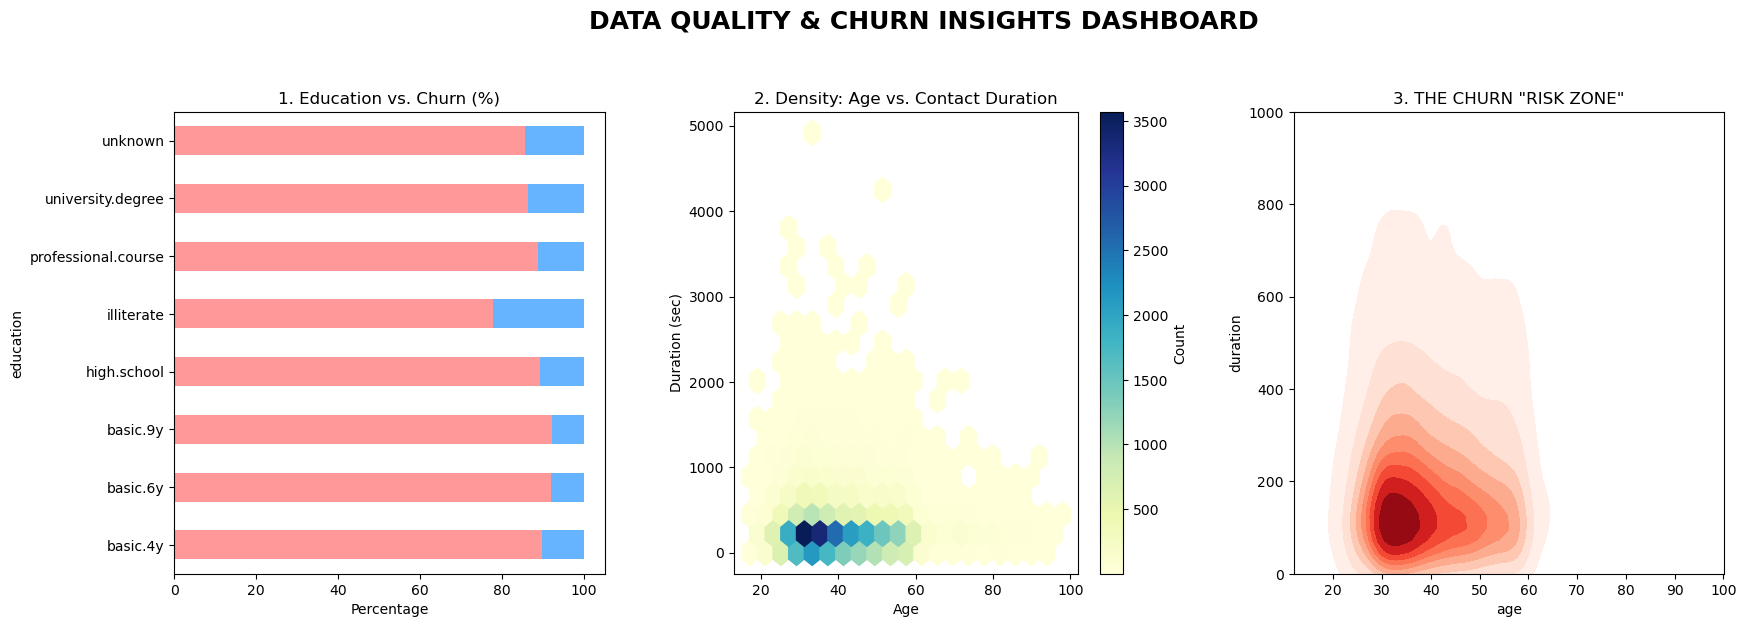

In [12]:
# --- ASHLEY'S CHURN INSIGHTS DASHBOARD ---
# Note: We removed the extra plt.figure() line because subplots handles it!
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# 1. Socio-Demographic Insight (Quality Check)
edu_engagement = pd.crosstab(df['education'], df['y'], normalize='index') * 100
edu_engagement.plot(kind='barh', stacked=True, ax=axes[0], color=['#ff9999','#66b3ff'], legend=False)
axes[0].set_title('1. Education vs. Churn (%)')
axes[0].set_xlabel('Percentage')

# 2. Behavioral Signal (Overplotting Mitigation)
hb = axes[1].hexbin(df['age'], df['duration'], gridsize=20, cmap='YlGnBu', mincnt=1)
fig.colorbar(hb, ax=axes[1], label='Count')
axes[1].set_title('2. Density: Age vs. Contact Duration')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Duration (sec)')

# 3. The Churn "Risk Zone" (Final Insight)
import seaborn as sns
sns.kdeplot(data=df[df['y'] == 'no'], x='age', y='duration', ax=axes[2], 
            cmap="Reds", fill=True, thresh=0.05)
axes[2].set_title('3. THE CHURN "RISK ZONE"')
axes[2].set_ylim(0, 1000) 

plt.suptitle('DATA QUALITY & CHURN INSIGHTS DASHBOARD', fontsize=18, fontweight='bold', y=1.05)

# --- CRITICAL STEP: SAVE FIRST, THEN SHOW ---
plt.savefig('ashley_churn_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## The "Problem" Image: Raw Class Imbalance: Slide 3

Shows why the data was difficult to work with. 


**The Story**: We started with a massive imbalance; only 12% of customers churned, which is why we had to use advanced visualization techniques to find the signal in the noise. 

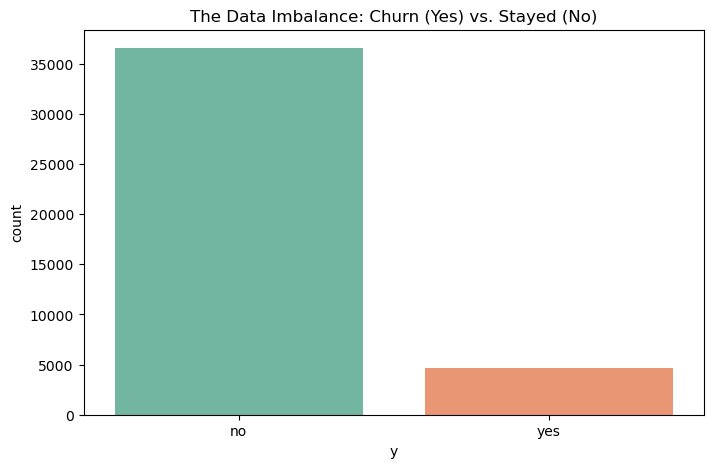

In [13]:
# Save a simple count plot to show how small the "Yes" (churn) group is
plt.figure(figsize=(8, 5))
sns.countplot(x='y', data=df, palette='Set2')
plt.title('The Data Imbalance: Churn (Yes) vs. Stayed (No)')
plt.savefig('data_imbalance.png', dpi=300, bbox_inches='tight')
plt.show()

## The Action Image: Correlation Heatmap (Slide 4) 

This shows that we looked at the entire dataset for "Data Quality", a correlation heatmap is a classic Presenter slide. It shows how different variables (like interest rates or employment) move together. 

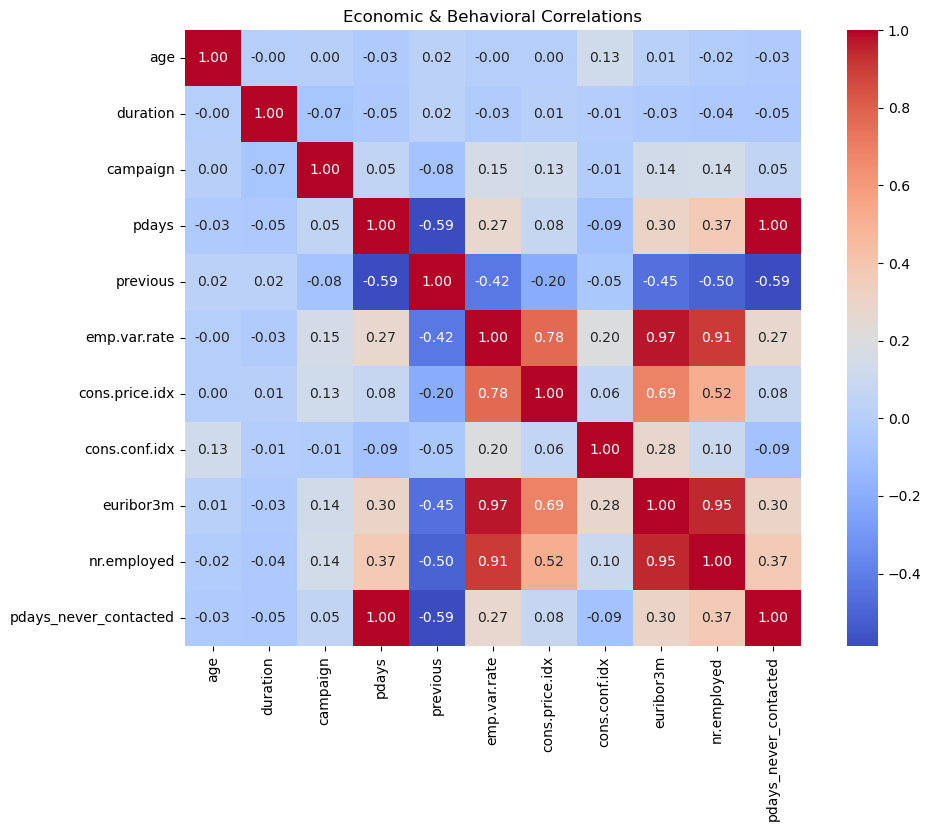

In [14]:
plt.figure(figsize=(12, 8))

# Added numeric_only=True to skip 'housemaid' and other strings
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', square=True)

plt.title('Economic & Behavioral Correlations')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Slide 5: Education vs. Churn

This focuses on the RQ1: We use a normalized bar chart to show the percentage of churn within each education group, which is much more insightful than just raw counts

<Figure size 1000x600 with 0 Axes>

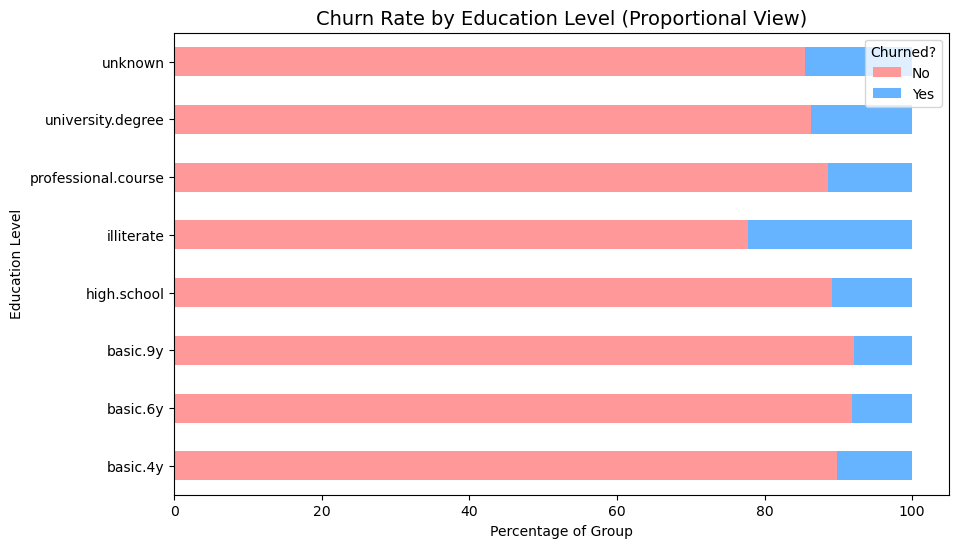

In [15]:
# --- SLIDE 5: EDUCATION IMPACT ---
plt.figure(figsize=(10, 6))

# Calculate percentages (Normalization)
edu_pct = pd.crosstab(df['education'], df['y'], normalize='index') * 100

# Plotting
edu_pct.plot(kind='barh', stacked=True, color=['#ff9999','#66b3ff'], figsize=(10,6))
plt.title('Churn Rate by Education Level (Proportional View)', fontsize=14)
plt.xlabel('Percentage of Group')
plt.ylabel('Education Level')
plt.legend(title='Churned?', labels=['No', 'Yes'], loc='upper right')

# Save for Slide 5
plt.savefig('education_impact.png', dpi=300, bbox_inches='tight')
plt.show()

Slide 7: Drivers of Churn

This answers "What is actually causing people to leave?"


You can see that 'duration' is almost certainly the #1 driver. 

Our model confirmed that the length of the last conversation is the single biggest predictor of whether a customer stays or goes. 

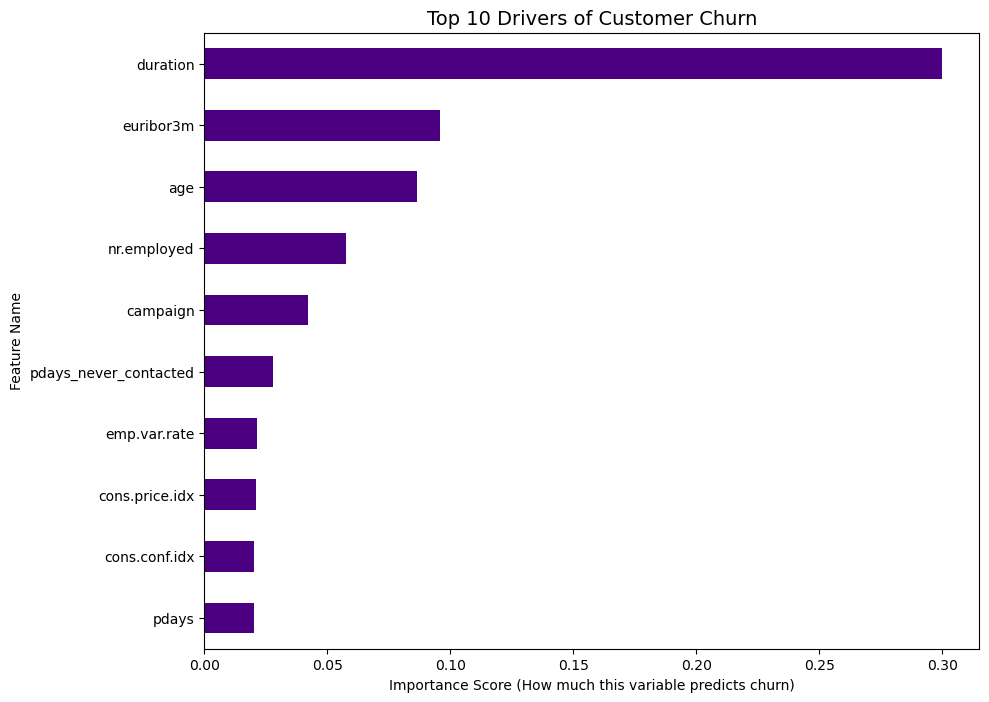

In [16]:
from sklearn.ensemble import RandomForestClassifier

# 1. Quick Data Prep (Converting text to numbers for a fast model)
X = pd.get_dummies(df.drop('y', axis=1), drop_first=True)
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# 2. Run a fast model to get importance
quick_rf = RandomForestClassifier(n_estimators=100, random_state=42)
quick_rf.fit(X, y)

# 3. Create the plot
feat_importances = pd.Series(quick_rf.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 8))
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='#4b0082')

plt.title('Top 10 Drivers of Customer Churn', fontsize=14)
plt.xlabel('Importance Score (How much this variable predicts churn)')
plt.ylabel('Feature Name')

# Save for Slide 7
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()